In [1]:
include("utils.jl")
using .Utils

In [2]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using Juno
using Statistics

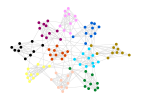

In [3]:
l = 10
k = 10
g = LightGraphs.SimpleGraphs.stochastic_block_model(0.8 * k, .2, k .* ones(UInt, l), seed = 1)
communities = [c for c in 1:l for i in 1:k]
features = Flux.normalise(Flux.onehotbatch(communities, 1:l))

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [4]:
palette

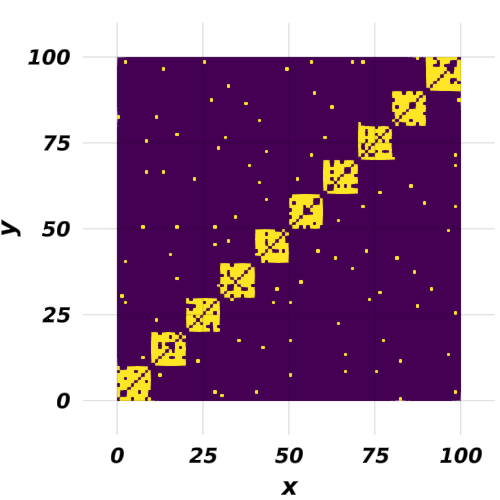

In [5]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, Array(adjacency_matrix(g)))

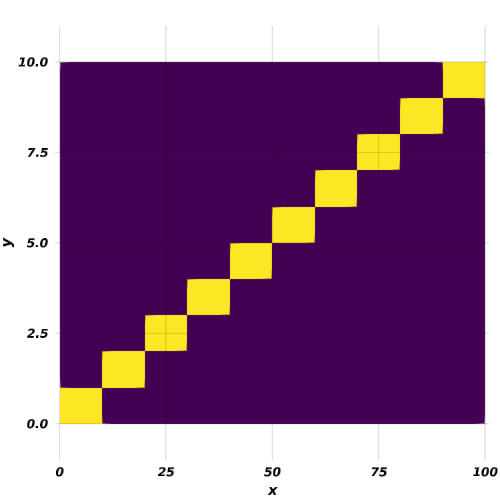

In [13]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, features)

In [14]:
module Layers


using Flux
using LinearAlgebra
using LightGraphs

nobias(out::Integer) = fill(nothing, out)
Flux.param(n::AbstractArray{Nothing}) = 0

adjacency_matrix_diag(g) = adjacency_matrix(g) + Matrix(I, size(g)...)

struct GC{T,U,F}
    Â::AbstractArray
    W::T
    b::U
    σ::F
    function GC(g::SimpleGraph, W::T, b::U, σ::F) where {T,U,F}
        Ã = adjacency_matrix_diag(g)
        Ãsumin_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 1), dims = 1))
        Ãsumout_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 2), dims = 2))
        Â = diagm(0 => Ãsumout_inv_sqrt) * Ã * diagm(0 => Ãsumin_inv_sqrt)
        new{T,U,F}(Â, W, b, σ)
    end
end

GC(g, W, b) = GC(g, W, b, identity)

function GC(g::SimpleGraph, in::Integer, out::Integer, σ = identity;
            initW = Flux.glorot_uniform, initb = zeros)
    return GC(g, param(initW(out, in)), param(initb(out)), σ)
end

Flux.@treelike GC

(a::GC)(x::AbstractArray) = a.σ.((a.W * x * a.Â) .+ a.b)

function Base.show(io::IO, l::GC)
    print(io, "GC(g ~ ", size(l.Â, 1), ", W ~ ", (size(l.W, 2), size(l.W, 1)), ", b ~ ")
    isa(l.b, TrackedArray) ? print(io, size(l.b, 1)) : print(io, "nothing")
    l.σ == identity || print(io, ", ", l.σ)
    print(io, ")")
end


struct Bilin{F}
    σ::F
end

Bilin() = Bilin(identity)

(a::Bilin)(x::AbstractArray) = a.σ.(transpose(x) * x)


end

Main.Layers

In [29]:
# TODO: make variational
diml1 = Int64(round(l / 2))
enc = Chain(Layers.GC(g, l, diml1, Flux.relu, initb = Layers.nobias),
            Layers.GC(g, diml1, 2, initb = Layers.nobias))
dec = Chain(Dense(2, diml1, Flux.relu, initb = Layers.nobias),
            Layers.Bilin())
ae = Chain(enc, dec)

Chain(Chain(GC(g ~ 100, W ~ (10, 5), b ~ nothing, NNlib.relu), GC(g ~ 100, W ~ (5, 2), b ~ nothing)), Chain(Dense(2, 5, NNlib.relu), Main.Layers.Bilin{typeof(identity)}(identity)))

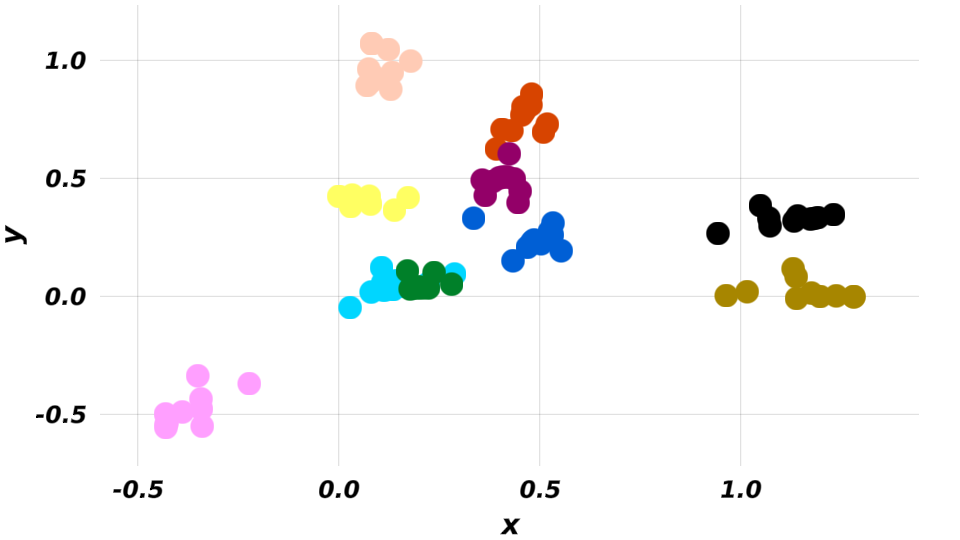

In [17]:
emb = enc(features)
scene = Scene(resolution = (500, 500))
scatter(emb[1, :], emb[2, :], color = colors)

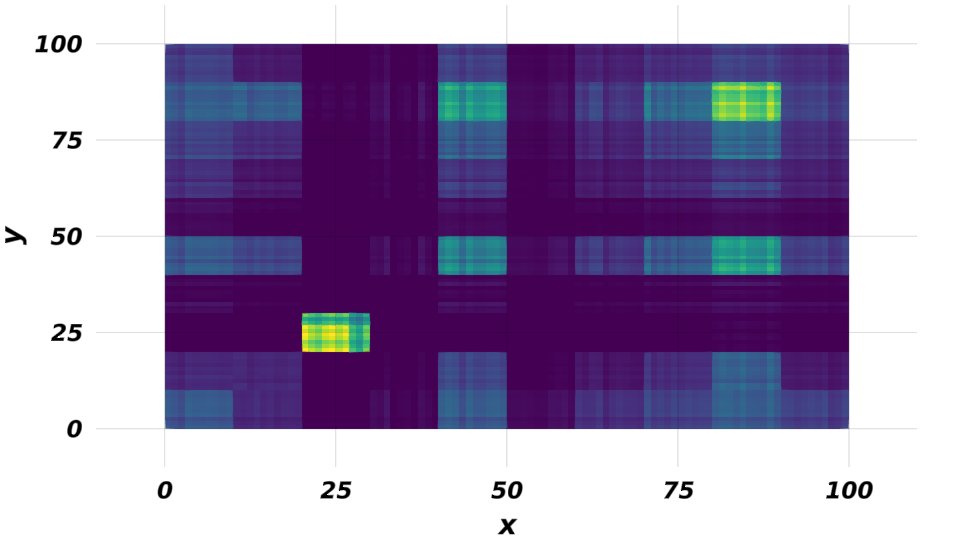

In [18]:
scene = Scene(resolution = (500, 500))
heatmap(ae(features).data)

In [34]:
# TODO: make clear which entropy function and weighing we're using, and add pos/neg weights
# TODO: check ref_api implementation details
reg() = 0.01 * sum(x -> sum(x.^2), params(dec))
La(X) = sum(Flux.logitbinarycrossentropy.(ae(X), Layers.adjacency_matrix_diag(g)))
loss(X) = La(X) / (size(g, 1)^2 * log(2)) + reg()

evalcb = Flux.throttle(() -> @show(loss(features)), 5)
opt = ADAM(params(ae))
Juno.@progress for i = 1:20000
  #@info "Epoch $i"
  Flux.train!(loss, zip([features]), opt, cb=evalcb)
end

loss(features) = 0.9938159497608641 (tracked)
loss(features) = 0.9905424111094483 (tracked)
loss(features) = 0.9903739414366095 (tracked)
loss(features) = 0.9903247241674685 (tracked)
loss(features) = 0.9902526438793515 (tracked)
loss(features) = 0.990126112643805 (tracked)
loss(features) = 0.990037060210844 (tracked)


In [31]:
loss(features)

0.9937139548667979 (tracked)

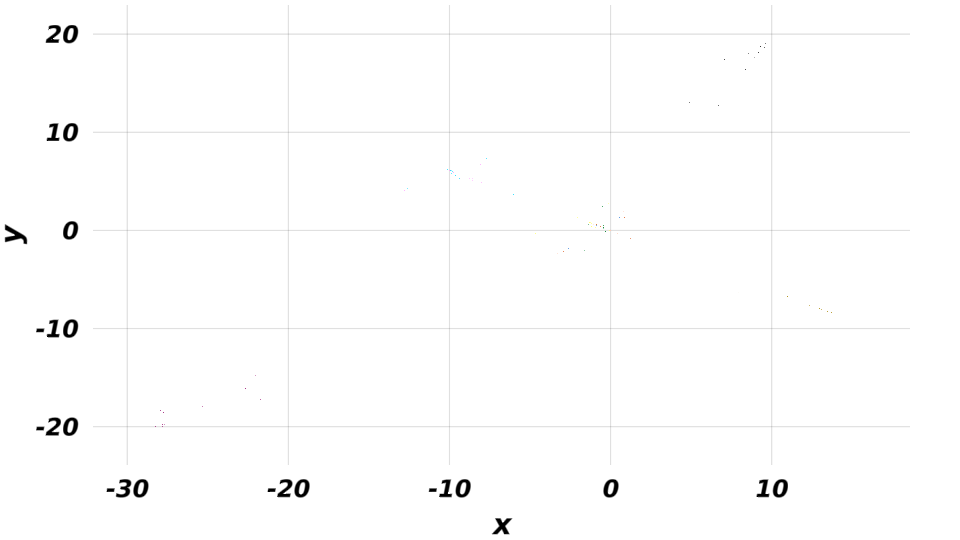

In [35]:
emb = enc(features)
scene = Scene(resolution = (500, 500))
scatter(emb[1, :], emb[2, :], color = colors)

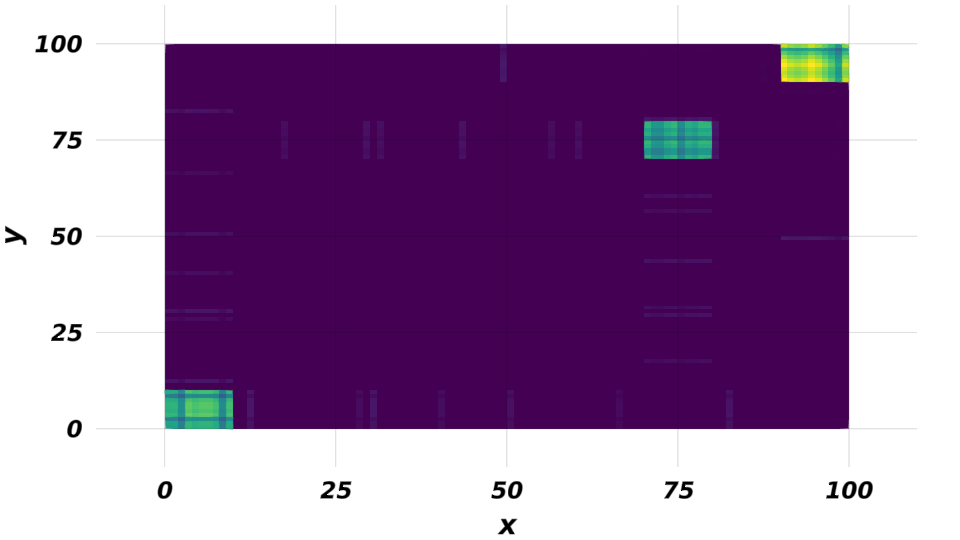

In [36]:
scene = Scene(resolution = (500, 500))
heatmap(ae(features).data)